# ResNet based Segmentation Model

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from cv2 import imread, resize, COLOR_BGR2RGB, cvtColor

2025-12-06 08:11:49.884935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set Data Paths

In [2]:
IMAGE_DIR = "/Users/anugrahrastogi21gmail.com/Downloads/archive (3)/data/Lung Segmentation/CXR_png/"
MASK_DIR = "/Users/anugrahrastogi21gmail.com/Downloads/archive (3)/data/Lung Segmentation/masks/"
IMG_HEIGHT, IMG_WIDTH = 256,256

# Load Images and Masks

In [3]:
def load_data(img_dir, mask_dir):
    
    X, y = [], []
    files = os.listdir(img_dir)
    
    for f in tqdm(files):
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_dir, f)

        if not os.path.exists(mask_path):
            continue

        img = imread(img_path)
        mask = imread(mask_path, 0)

        img = resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        img = cvtColor(img, COLOR_BGR2RGB)
        mask = np.expand_dims(mask, axis=-1)

        X.append(img / 255)
        y.append(mask / 255)

    return np.array(X), np.array(y)


X, y = load_data(IMAGE_DIR, MASK_DIR)
print(X.shape, y.shape)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:30<00:00, 26.42it/s]


(138, 256, 256, 3) (138, 256, 256, 1)


# Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


# Build ResNet Segmentation Model

In [5]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_resnet_segmentation(input_shape=(256, 256, 3)):
    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base.trainable = False

    x = base.output
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(1, 1, activation='sigmoid')(x)
    x = layers.UpSampling2D((4, 4))(x)

    model = models.Model(inputs=base.input, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_resnet_segmentation()
model.summary()
model.save("best_resnet_segmentation_model.h5")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

/Users/anugrahrastogi21gmail.com/Documents/opencv_project/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Train Model

In [6]:
EPOCHS = 8
BATCH = 4

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH
)


Epoch 1/8
28/28 [==============================] - 19s 612ms/step - loss: 0.8420 - accuracy: 0.7887 - val_loss: 0.2956 - val_accuracy: 0.8726
Epoch 2/8
28/28 [==============================] - 17s 593ms/step - loss: 0.2843 - accuracy: 0.8751 - val_loss: 0.2678 - val_accuracy: 0.8877
Epoch 3/8
28/28 [==============================] - 16s 576ms/step - loss: 0.2645 - accuracy: 0.8831 - val_loss: 0.2469 - val_accuracy: 0.8922
Epoch 4/8
28/28 [==============================] - 16s 577ms/step - loss: 0.2412 - accuracy: 0.8948 - val_loss: 0.2405 - val_accuracy: 0.8938
Epoch 5/8
28/28 [==============================] - 16s 573ms/step - loss: 0.2403 - accuracy: 0.8946 - val_loss: 0.2320 - val_accuracy: 0.8994
Epoch 6/8
28/28 [==============================] - 16s 592ms/step - loss: 0.2375 - accuracy: 0.8950 - val_loss: 0.2358 - val_accuracy: 0.8951
Epoch 7/8
28/28 [==============================] - 17s 626ms/step - loss: 0.2296 - accuracy: 0.8984 - val_loss: 0.2321 - val_accuracy: 0.8987
Epoch 

# Evaluate Model

In [7]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

1/1 [==============================] - 4s 4s/step - loss: 0.2340 - accuracy: 0.8972
Test Loss: 0.2339954674243927
Test Accuracy: 0.8972004652023315


# Plot Training vs Validation Accuracy

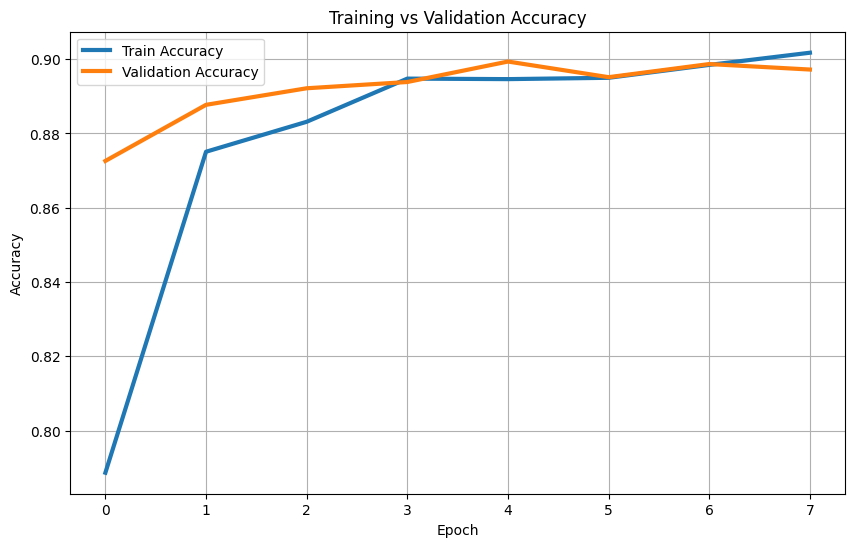

Final Train Accuracy: 0.9017273187637329
Final Validation Accuracy: 0.8972004652023315


In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy', linewidth=3)
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', linewidth=3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

final_train_acc = history.history.get('accuracy', [None])[-1]
final_val_acc = history.history.get('val_accuracy', [None])[-1]

print("Final Train Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)


# Predict and Visualize Results

1/1 [==============================] - 1s 559ms/step


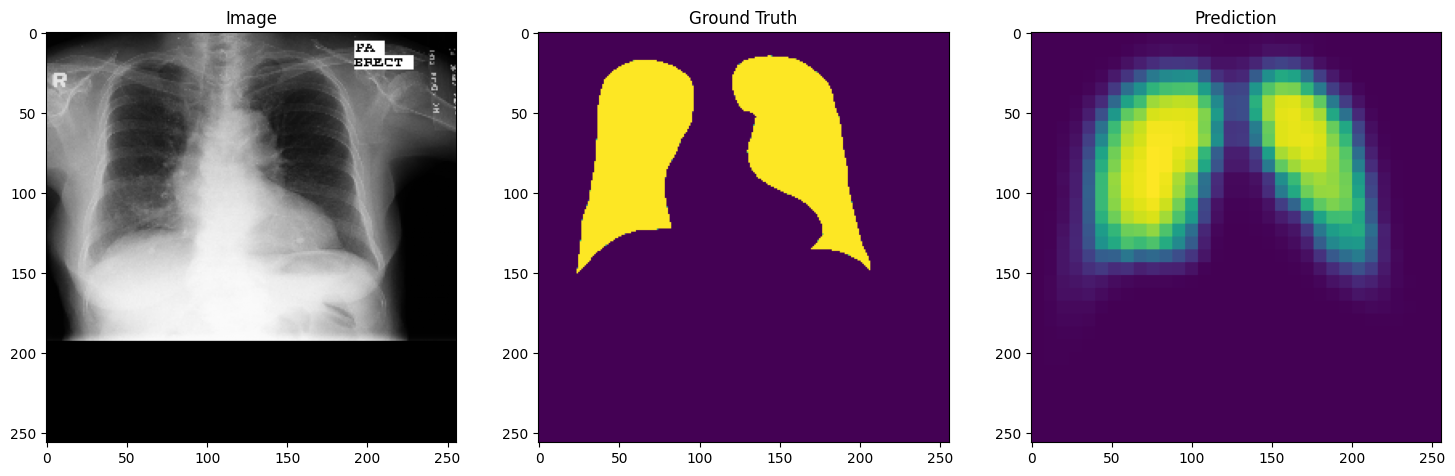

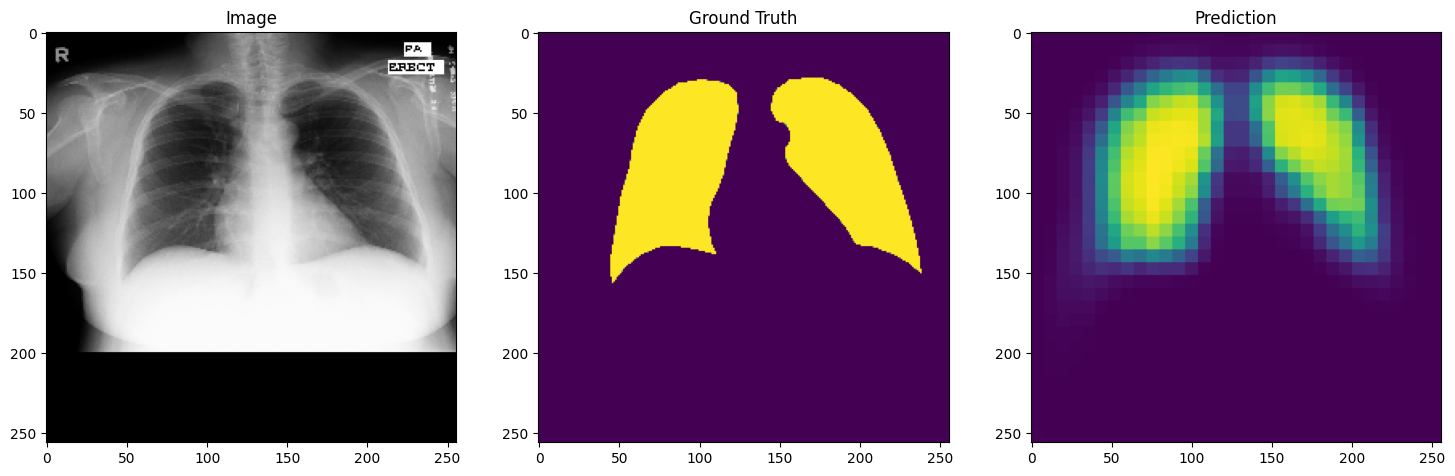

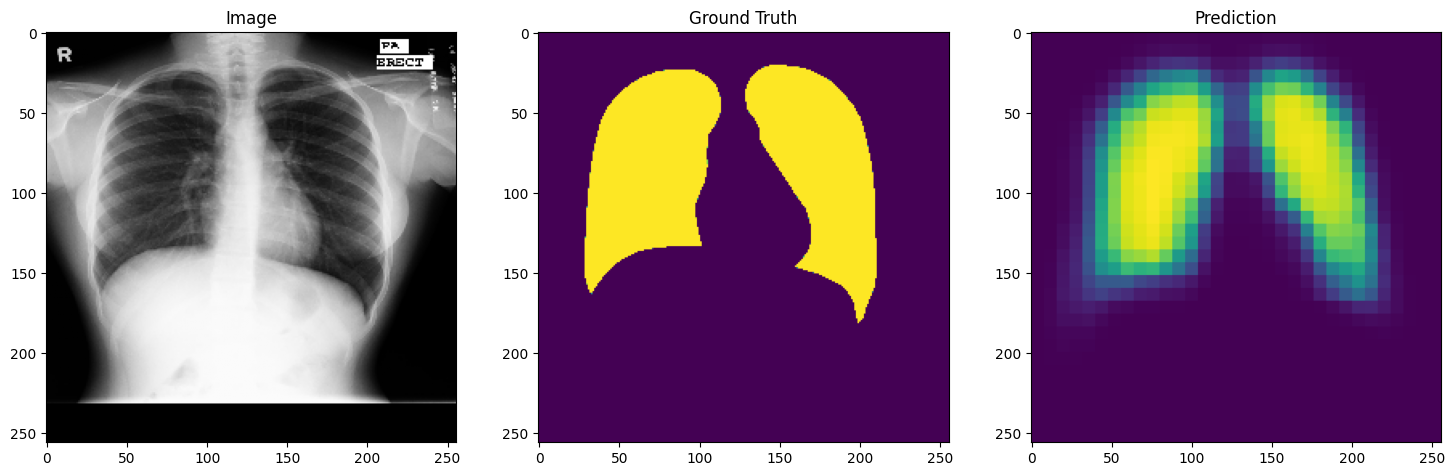

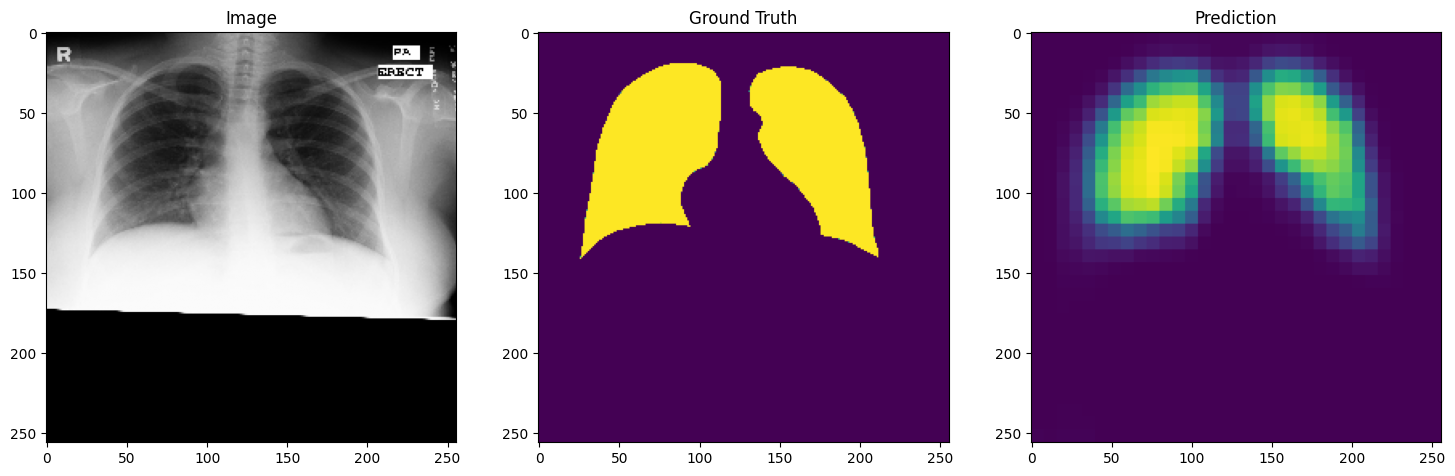

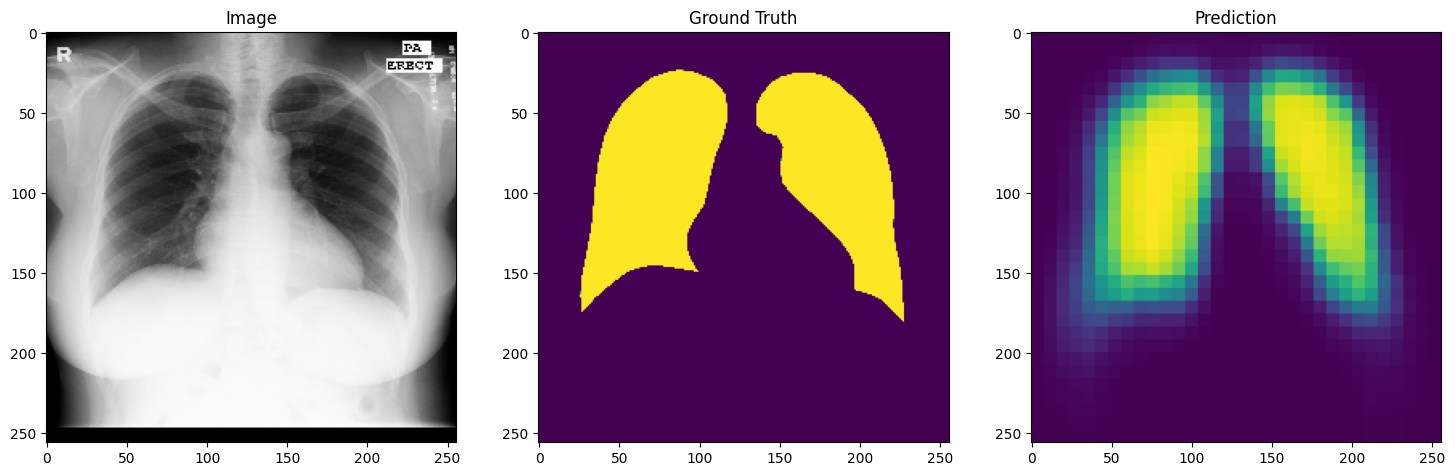

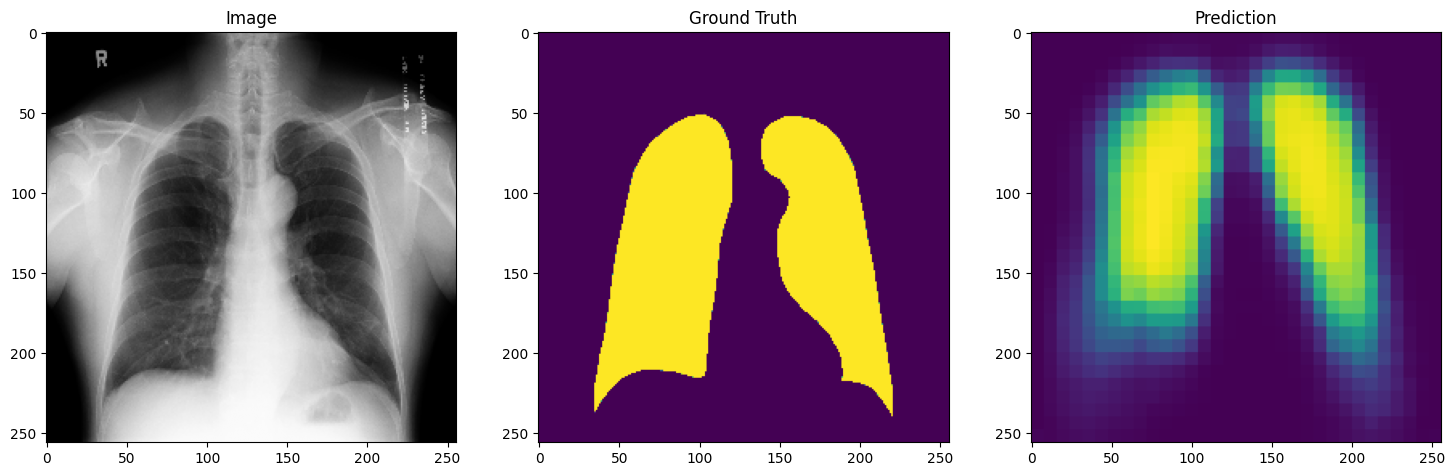

In [10]:
preds = model.predict(X_test[:6])

for i in range(6):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze())
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze())
    plt.title("Prediction")

    plt.show()
